In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.tree as tree
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Loading the Data Sets

/kaggle/input/titanic/train.csv

/kaggle/input/titanic/test.csv

/kaggle/input/titanic/gender_submission.csv

In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')  
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Splitting the Train Data into attributes and target variable

First, we aggregate the attributes that seem influential to the Survivability of the subject on the X_train dataframe: their Sex, Age, the class of their ticket, and if they had any family on the boat.

We also separate the Survived column to a different dataframe, as the target dataframe, y_train.

In [3]:
X_train = train_data[['Sex', 'Age', 'Pclass', 'SibSp', 'Parch']]
y_train = train_data[['Survived']]
X_train.head()

,Sex,Age,Pclass,SibSp,Parch
0,male,22.0,3,1,0
1,female,38.0,1,1,0
2,female,26.0,3,0,0
3,female,35.0,1,1,0
4,male,35.0,3,0,0


The Sex column is currently categorical, as it only possesses 2 values (male or female), it is changed into a binary column.

At the same time, information about the X_train dataframe is obtained through the describe() method.

In [4]:
X_train['Sex'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
X_train.describe()

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,Sex,Age,Pclass,SibSp,Parch
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.352413,29.699118,2.308642,0.523008,0.381594
std,0.477990,14.526497,0.836071,1.102743,0.806057
min,0.000000,0.420000,1.000000,0.000000,0.000000
25%,0.000000,20.125000,2.000000,0.000000,0.000000
50%,0.000000,28.000000,3.000000,0.000000,0.000000
75%,1.000000,38.000000,3.000000,1.000000,0.000000
max,1.000000,80.000000,3.000000,8.000000,6.000000


It is noticeable the count of the Age variable is lower, this means there are missing values, as comproved by the following operation.

In [5]:
pd.isna(X_train).sum()

Sex         0
Age       177
Pclass      0
SibSp       0
Parch       0
dtype: int64

There are a total of 177 missing values from the Age column.

Instead of dropping the rows in which the variable is missing, we insert the mean of the column in the missing rows.

In [6]:
X_train.fillna(X_train['Age'].mean(), inplace=True)
X_train.describe()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,Sex,Age,Pclass,SibSp,Parch
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.352413,29.699118,2.308642,0.523008,0.381594
std,0.477990,13.002015,0.836071,1.102743,0.806057
min,0.000000,0.420000,1.000000,0.000000,0.000000
25%,0.000000,22.000000,2.000000,0.000000,0.000000
50%,0.000000,29.699118,3.000000,0.000000,0.000000
75%,1.000000,35.000000,3.000000,1.000000,0.000000
max,1.000000,80.000000,3.000000,8.000000,6.000000


Now that the missing values are gone, we evaluate the correlation between each selected attribute and the target variable

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0.5, 0, 'Sex'),
  Text(1.5, 0, 'Age'),
  Text(2.5, 0, 'Pclass'),
  Text(3.5, 0, 'SibSp'),
  Text(4.5, 0, 'Parch'),
  Text(5.5, 0, 'Survived')])

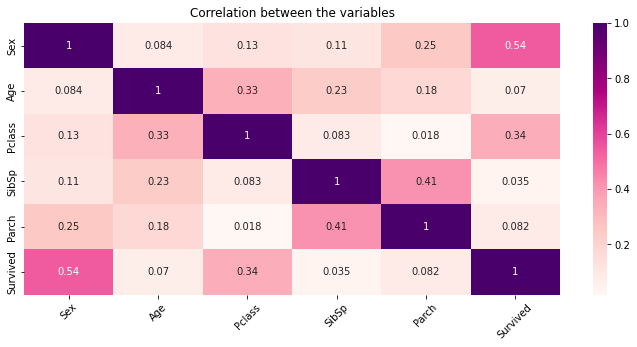

In [7]:
#correlation matrix and the heatmap
heatmap_df = pd.concat([X_train, y_train], axis=1)
plt.subplots(figsize=(12,5))
correlation=abs(heatmap_df.corr())
sns.heatmap(correlation,annot=True,cmap='RdPu')
plt.title('Correlation between the variables')
plt.xticks(rotation=45)

At face value, we can conclude that only 2 attributes affect the survivability of the passenger, their Sex and the class of their ticket.

As such, for a first iteration, we'll eliminate all variables but the Sex and the ticket class.

In [8]:
X_train = train_data[['Sex', 'Pclass']]
X_train['Sex'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
X_train.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,Sex,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


In [9]:
X_test = test_data[['Sex','Pclass']]
X_test['Sex'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
X_test.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,Sex,Pclass
0,0,3
1,1,3
2,0,2
3,0,3
4,1,3


As a final data treatment phase, we'll normalize the data

In [10]:
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_train[0:5]

array([[-0.73769513,  0.82737724],
       [ 1.35557354, -1.56610693],
       [ 1.35557354,  0.82737724],
       [ 1.35557354, -1.56610693],
       [-0.73769513,  0.82737724]])

In [11]:
y_train = train_data['Survived'].values
y_train[0:5]

array([0, 1, 1, 1, 0])

# It's Machine Learning time


## Logistic Regression

In [12]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg_cv=GridSearchCV(LogisticRegression(solver='liblinear'),grid, cv=10) #solver set to liblinear so it can handle l1 penalty
logreg_cv.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2'}
accuracy : 0.786729088639201


In [13]:
logreg=LogisticRegression(C=0.001, penalty='l2', solver='liblinear')
logreg.fit(X_train, y_train)

LogisticRegression(C=0.001, solver='liblinear')

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


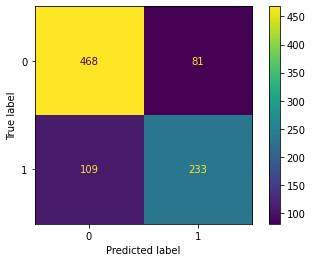

In [14]:
plot_confusion_matrix(logreg, X_train, y_train,values_format='d')

## Decision Tree

In [15]:
tree_param = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
dtree_cv=GridSearchCV(DecisionTreeClassifier(), tree_param, cv=10)
dtree_cv.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ",dtree_cv.best_params_)
print("accuracy :",dtree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 4}
accuracy : 0.7733208489388266


In [16]:
dtree=DecisionTreeClassifier(criterion='gini', max_depth=6)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6)

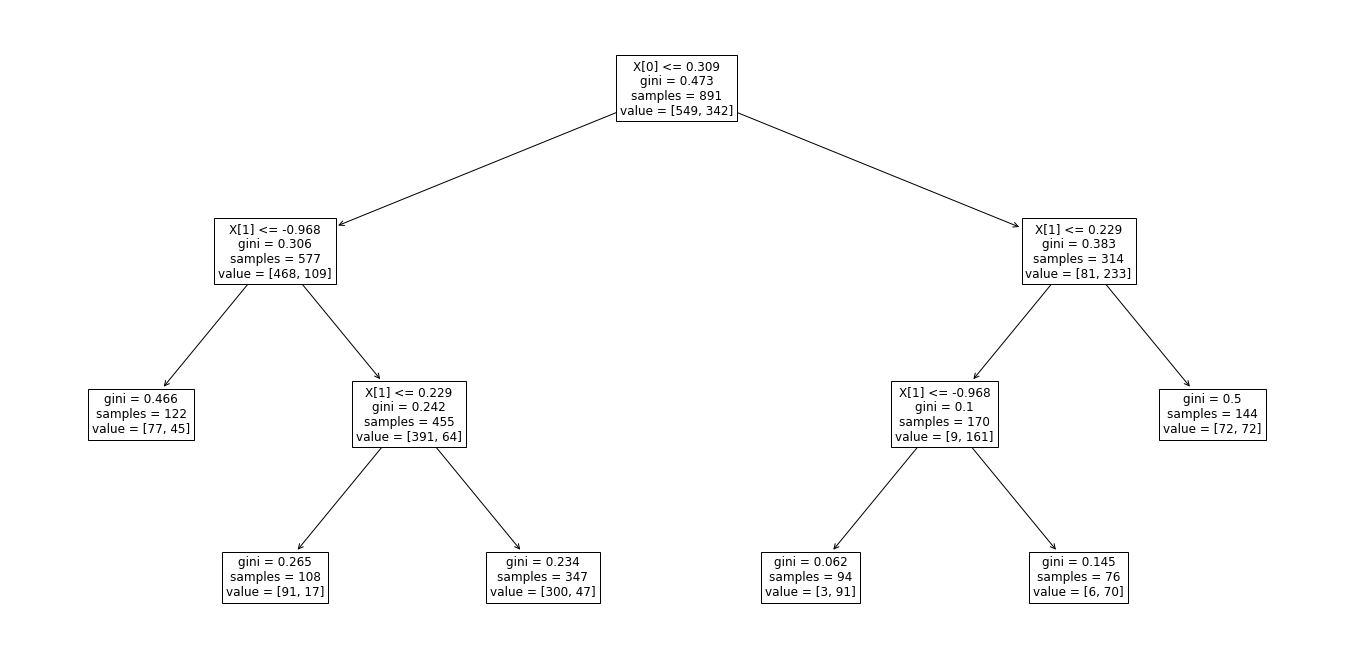

In [17]:
plt.figure(figsize=(24,12))
tree.plot_tree(dtree, fontsize=12)
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


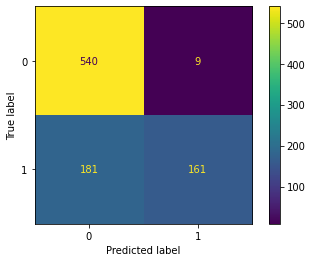

In [18]:
plot_confusion_matrix(dtree,X_train, y_train,values_format='d')

## KNN

In [19]:
k_range=list(range(1,31))
param_grid=dict(n_neighbors=k_range)
knn_cv=GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
knn_cv.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 4}
accuracy : 0.790099875156055


In [20]:
knn=KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


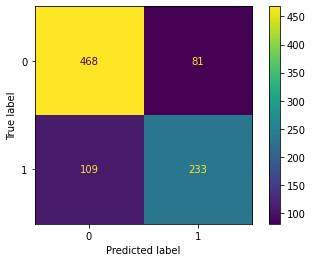

In [21]:
plot_confusion_matrix(knn,X_train, y_train,values_format='d')

## SVM

In [22]:
svm_param = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
svm_cv = GridSearchCV(SVC(), svm_param, refit = True, cv=10)
svm_cv=svm_cv.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
accuracy : 0.786729088639201


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


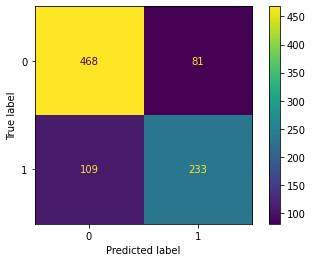

In [23]:
svm=SVC(C=0.1, gamma=0.1, kernel='rbf')
svm.fit(X_train, y_train)
plot_confusion_matrix(svm,X_train, y_train,values_format='d' )

At this point, any of the algorithms have an accuracy of around 78%. I will go for the KNN algorithm due to personal bias.

In [24]:
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
yhat = knn.predict(X_test)
yhat = pd.Series(data=yhat)
yhat = yhat.rename('Survived')
test_data['PassengerId']
result = pd.concat([test_data['PassengerId'], yhat], axis=1)
result.to_csv('/kaggle/working/result.csv', index=False)